In [1]:
import sys
sys.path.append("../")

import torch
import torchvision
from torch.utils.data import DataLoader

from mrl.encoders import resnet18, resnet50
from mrl.aug import get_inference_transforms

import warnings

warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/wavelet/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
IMAGE_SIZE = 32

transform = get_inference_transforms(image_size=(IMAGE_SIZE, IMAGE_SIZE))
train_ds = torchvision.datasets.CIFAR10("../data/cifar",
                                  train=True,
                                  transform=transform,
                                  download=True)
val_ds = torchvision.datasets.CIFAR10("../data/cifar",
                                  train=False,
                                  transform=transform,
                                  download=True)

train_loader = DataLoader(train_ds,
                          batch_size=256,
                          num_workers=4)
val_loader = DataLoader(val_ds,
                       batch_size=256,
                       num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
ckpt = torch.load("../models/encoder_resnet18_cifar10_80k.pth")

# model = resnet50()
model = resnet18(modify_model=True)
model.load_state_dict(ckpt)

model = model.eval().to(device)

In [7]:
from tqdm.auto import tqdm
import numpy as np

def get_embs_labels(dl, feature_dim, verbose):
    idx = 0
    embs, labels = [], []
    data = tqdm(dl) if verbose else dl
    for idx, (images, targets) in enumerate(data):
        with torch.no_grad():
            images = images.to(device)
            out = model(images)
            features = out.cpu().detach()
            features = features[:, :feature_dim]
            embs.extend(features.tolist())
            labels.extend(targets.cpu().detach().tolist())
    return np.array(embs), np.array(labels)

In [8]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def logistic_regression(feature_dim, verbose=False):
    embeddings, labels = get_embs_labels(train_loader, feature_dim, verbose)
    embeddings_val, labels_val = get_embs_labels(val_loader, feature_dim, verbose)
    
    X_train, X_test = embeddings, embeddings_val
    y_train, y_test = labels, labels_val

    if verbose:
        print("train", X_train.shape[0], len(y_train))
        print("test", X_test.shape[0], len(y_test))
        print(embeddings.shape)
        print(labels.shape)
        print(embeddings_val.shape)
        print(labels_val.shape)
    
    clf = LogisticRegression(max_iter=100)
    clf = CalibratedClassifierCV(clf)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    

    print(f"Accuracy ({feature_dim}): ", acc)
    
    if verbose:
        print("Confusion matrix: \n", conf_matrix)
        print("Classification report: \n", class_report)
        
        y_pred_train = clf.predict(X_train)
        class_report = classification_report(y_train, y_pred_train)
        print("Classification report train: \n", class_report)

    return acc

In [8]:
logistic_regression(64, True)

100%|██████████| 40/40 [00:00<00:00, 63.47it/s]


train 50000 50000
test 10000 10000
(50000, 64)
(50000,)
(10000, 64)
(10000,)
Accuracy (64):  0.8313
Confusion matrix: 
 [[884   0  18  30   9   1   3   1  43  11]
 [  9 933   4   2   0   0   1   0  23  28]
 [ 48   0 682  91  89  16  59   9   4   2]
 [  5   1  17 826  37  31  68  11   1   3]
 [  6   0  18  45 857   9  20  42   3   0]
 [  2   0  15 402  35 482  30  34   0   0]
 [  8   0  11  52   7   6 916   0   0   0]
 [  6   0   4  57  29  10   1 893   0   0]
 [ 21   2   3  17   1   2   2   0 946   6]
 [ 16  40   0  12   0   0   1   1  36 894]]
Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      1000
           1       0.96      0.93      0.94      1000
           2       0.88      0.68      0.77      1000
           3       0.54      0.83      0.65      1000
           4       0.81      0.86      0.83      1000
           5       0.87      0.48      0.62      1000
           6       0.83      0.92      0.87  

0.8313

In [9]:
import math

FEATURE_DIM = 512

nesting_dims = [2**i for i in range(3, int(math.log2(FEATURE_DIM)) + 1)]
accs = []
for dim in nesting_dims:
    accs.append(logistic_regression(dim))


Accuracy (8):  0.727
Accuracy (16):  0.781
Accuracy (32):  0.8238
Accuracy (64):  0.8313
Accuracy (128):  0.8332
Accuracy (256):  0.8422
Accuracy (512):  0.8419


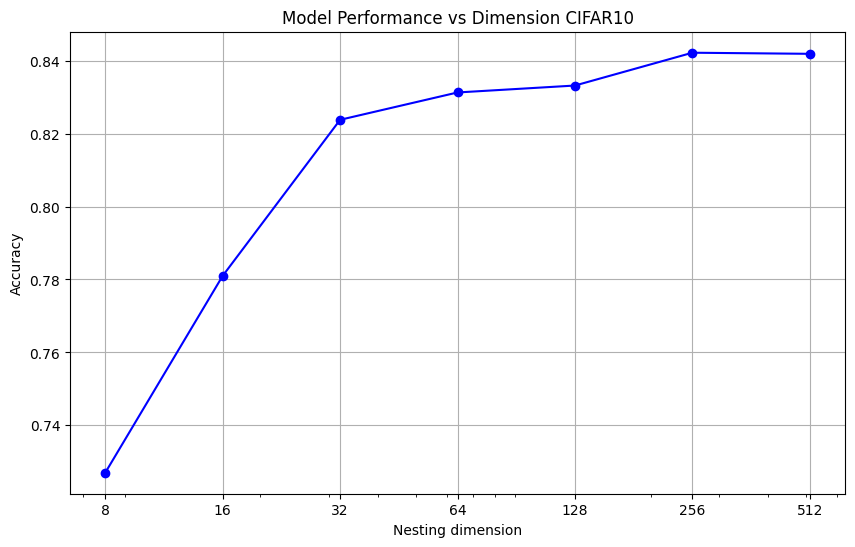

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(nesting_dims, accs, marker='o', linestyle='-', color='b')

plt.title('Model Performance vs Dimension CIFAR10')
plt.xlabel('Nesting dimension')
plt.ylabel('Accuracy')

plt.xscale('log')
plt.xticks(nesting_dims, labels=[str(dim) for dim in nesting_dims])
plt.grid(True) 

plt.show()
